In [1]:
from collections import defaultdict
from itertools import product
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from algorithms.nn import NeuralNetwork
from algorithms.preprocessing import load_and_preprocess_dataset
from algorithms.model_selection import DEFAULT_METRICS
import config

In [2]:
X_train, y_train, X_test, y_test = load_and_preprocess_dataset()
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [3]:
ridge_logs_dir = config.LOGS_DIR / 'ridge'
nn_logs_dir = config.LOGS_DIR / 'nn'
svr_logs_dir = config.LOGS_DIR / 'svr'

In [4]:
nn_layers_list = [
    [32, 1],
    [64, 1],
    [32, 32, 1],
    [64, 64, 1],
]
nn_alphas = [1e-2, 5e-3, 1e-3, 5e-4]
nn_momentums = [0.85, 0.95]
nn_batch_sizes = [32, 64]

nn_hyperparams = list(product(nn_layers_list, nn_alphas, nn_momentums, nn_batch_sizes))

In [5]:
nn_scores = []
for layers, alpha, momentum, batch_size in nn_hyperparams:
    with open(nn_logs_dir / f'alpha_{alpha}-momentum_{momentum}-batch_size_{batch_size}-layers_{"_".join([str(x) for x in layers])}.pkl', 'rb') as f:
        nn_histories = pickle.load(f)
    nn_scores.append(nn_histories)

In [6]:
nn_last_scores = []

for model in nn_scores:
    model_last_scores = defaultdict(int)
    for fold in model:
        for metric in DEFAULT_METRICS.keys():
            model_last_scores[f'train_{metric}'] += fold[f'train_{metric}'][-1] / len(model)
            model_last_scores[f'valid_{metric}'] += fold[f'valid_{metric}'][-1] / len(model)
    nn_last_scores.append(model_last_scores)

In [7]:
nn_best_score = np.inf
nn_best_model_index = -1

for i, model in enumerate(nn_last_scores):
    if model['valid_MAPE'] < nn_best_score:
        nn_best_model_index = i
        nn_best_score = model['valid_MAPE']

In [8]:
valid_nn = {metric: [ls[f'valid_{metric}'] for ls in nn_last_scores] for metric in DEFAULT_METRICS.keys()}

In [9]:
print(np.mean(valid_nn['MSE']), np.std(valid_nn['MSE']))

0.2979528316851958 0.17074813144774242


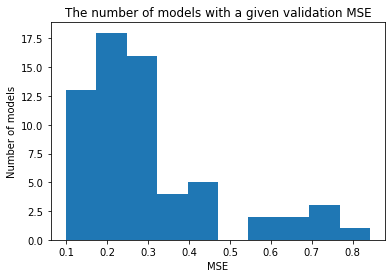

In [10]:
plt.figure()
plt.title('The number of models with a given validation MSE')
plt.xlabel('MSE')
plt.ylabel('Number of models')
plt.hist(valid_nn['MSE'])
plt.show()

In [11]:
nn_hyperparams[nn_best_model_index]

([64, 64, 1], 0.01, 0.85, 32)

In [12]:
for k, v in nn_last_scores[nn_best_model_index].items():
    if k.startswith('train'):
        print(k, v)

train_MSE 0.09611180463463619
train_MAE 0.1643162377818863
train_MAPE 1.271877502520959
train_R2 0.9322010903377901


In [13]:
for k, v in nn_last_scores[nn_best_model_index].items():
    if k.startswith('valid'):
        print(k, v)

valid_MSE 0.09839532513156464
valid_MAE 0.16349986456628834
valid_MAPE 0.8987030178740392
valid_R2 0.9034182603120198


In [14]:
best_model = NeuralNetwork(n_neurons=[64, 64, 1])
history = best_model.fit(X_train, y_train, X_test, y_test, alpha=0.01, batch_size=32, momentum=0.85,epochs=500, patience=50, min_delta=1e-4)

n_neurons=64-64-1, alpha=0.01, momentum=0.85, batch_size=32: 100%|██████████| 500/500 [01:05<00:00,  7.64it/s, train_mse=0.0415422, valid_mse=0.4606246]


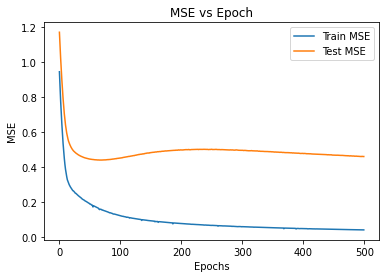

In [15]:
h = pd.DataFrame.from_dict(history)[['train_MSE', 'valid_MSE']]
h = h.set_axis(['Train MSE', 'Test MSE'], axis=1)
h.plot()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE vs Epoch')
plt.show()